In [2]:
!pip install kaggle


In [3]:

from google.colab import files
files.upload()  # This will prompt you to upload the Kaggle API key file (kaggle.json)


KeyboardInterrupt: 

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d ayuraj/asl-dataset


 98% 56.0M/56.9M [00:00<00:00, 89.6MB/s]
100% 56.9M/56.9M [00:00<00:00, 83.0MB/s]


In [ ]:
!unzip asl-dataset.zip -d dataset_folder


unzip:  cannot find or open asl-dataset.zip, asl-dataset.zip.zip or asl-dataset.zip.ZIP.


In [ ]:
directory = '/content/dataset_folder/asl_dataset'


In [ ]:
directory


'/content/dataset_folder/asl_dataset'

In [ ]:
!pip install opencv-python scikit-learn keras


[BernoulliRBM] Iteration 1, pseudo-likelihood = -943.61, time = 12.41s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -842.71, time = 12.89s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -816.77, time = 12.92s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -794.61, time = 12.92s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -775.90, time = 12.95s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -758.75, time = 12.85s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -754.02, time = 12.76s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -746.27, time = 12.96s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -740.20, time = 13.05s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -737.66, time = 12.93s
Epoch 1/100
126/126 [==============================] - 2s 9ms/step - loss: 40.5858 - accuracy: 0.6685 - val_loss: 0.4971 - val_accuracy: 0.8260
Epoch 2/100
126/126 [==============================] - 1s 12ms/step - loss: 14.0725 - accuracy: 0.8546 - val_loss: 0.3568 - val_accuracy: 0.8807


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


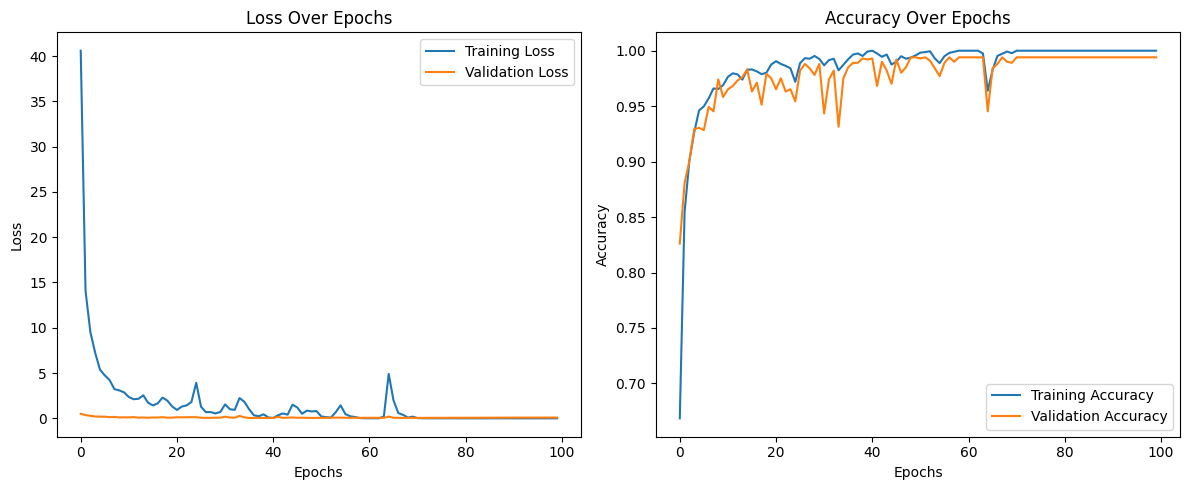

32/32 [==============================] - 0s 3ms/step


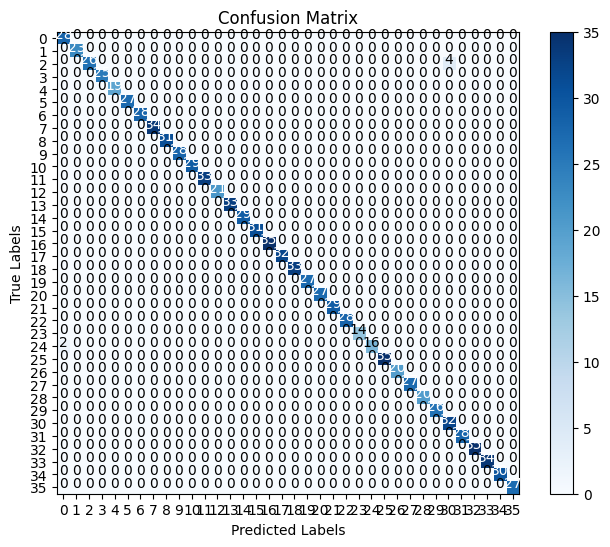

Accuracy: 99.40%
Precision: 0.99
Recall: 0.99


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from sklearn.neural_network import BernoulliRBM
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt

# Function to load dataset from subfolders
def load_dataset(folder_path):
    labels, images = [], []
    for subdir, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
                img_path = os.path.join(subdir, file)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (32, 32))
                images.append(img.flatten())  # Flatten the image into a 1D array
                label = subdir.split(os.sep)[-1]
                labels.append(label)
    return np.array(images), np.array(labels)

# Load the dataset (update the path based on your uploaded dataset)
images, labels = load_dataset('/content/dataset_folder/asl_dataset')  # Update this path

# Normalize pixel values
features = images / 255.0

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split dataset into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Calculate class weights for handling class imbalance
class_counts = np.bincount(labels_train)
total_samples = len(labels_train)
class_weights = {i: total_samples / count for i, count in enumerate(class_counts)}

# RBM Model for feature extraction
rbm = BernoulliRBM(n_components=256, learning_rate=0.01, n_iter=10, random_state=0, verbose=True)
features_train_rbm = rbm.fit_transform(features_train)
features_test_rbm = rbm.transform(features_test)

# Deep Neural Network Model
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(256,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(np.max(labels) + 1, activation='softmax'))  # Output layer with softmax activation for multi-class classification

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(features_train_rbm, labels_train, epochs=100, batch_size=32, validation_data=(features_test_rbm, labels_test), class_weight=class_weights)

# Save the trained model
model.save('/content/sign_language_model.h5')
print("Training completed. Model saved.")

# Plot loss and accuracy graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()

# Make predictions on the test set
predictions_probabilities = model.predict(features_test_rbm)
predictions = np.argmax(predictions_probabilities, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix')
plt.colorbar()

n_classes = np.max(labels) + 1
classes = np.arange(n_classes)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

# Print evaluation metrics
print("Accuracy: {:.2f}%".format(accuracy_score(labels_test, predictions) * 100))
print("Precision: {:.2f}".format(precision_score(labels_test, predictions, average='weighted')))
print("Recall: {:.2f}".format(recall_score(labels_test, predictions, average='weighted')))


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Predict probabilities for test set
predictions_probabilities = model.predict(features_test_rbm)

# Binarize the labels
n_classes = len(label_encoder.classes_)
labels_binarized = label_binarize(labels_test, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], predictions_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Sign Language Recognition')
plt.legend(loc='lower right')
plt.show()


NameError: ignored

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving hand1_k_left_seg_3_cropped.jpeg to hand1_k_left_seg_3_cropped.jpeg


In [ ]:
import cv2
import numpy as np

# Function to preprocess uploaded image and make prediction
def predict_sign_language(image_path):
    # Read the uploaded image
    img = cv2.imread(image_path)
    # Resize the image to match the input size of the model
    img = cv2.resize(img, (32, 32))
    # Flatten the image into a 1D array and normalize pixel values
    img_array = img.flatten() / 255.0
    # Transform features using the RBM model
    img_rbm = rbm.transform([img_array])
    # Make prediction using the neural network model
    predicted_probabilities = model.predict(img_rbm)
    # Get the predicted class index
    predicted_class_idx = np.argmax(predicted_probabilities)
    return predicted_class_idx

# Get the path of the uploaded image (modify the filename accordingly)
image_path = 'hand1_k_left_seg_3_cropped.jpeg'  # Replace with the actual filename

# Make prediction
predicted_class_idx = predict_sign_language(image_path)

# Decode the predicted class index back to the corresponding label
predicted_letter = label_encoder.classes_[predicted_class_idx]

# Print the predicted letter
print("Predicted sign language letter:", predicted_letter)


1/1 [==============================] - 0s 35ms/step
Predicted sign language letter: k
